# Imports

In [1]:
from pymongo import MongoClient

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import BallTree
from gensim import matutils, models
import gensim
import matplotlib.pyplot as plt

%matplotlib inline

/Users/Sam/anaconda2/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


# Getting Data From MongoDB

In [4]:
client = MongoClient()
db = client.yelp
reviews = db.reviews
business = db.business

In [4]:
databus = list(business.find({"name": "Mr Hoagie"}))

In [5]:
print databus

[{u'city': u'Dravosburg', u'review_count': 7, u'name': u'Mr Hoagie', u'neighborhoods': [], u'type': u'business', u'business_id': u'5UmKMjUEUNdYWqANhGckJw', u'full_address': u'4734 Lebanon Church Rd\nDravosburg, PA 15034', u'hours': {u'Tuesday': {u'close': u'21:00', u'open': u'11:00'}, u'Friday': {u'close': u'21:00', u'open': u'11:00'}, u'Monday': {u'close': u'21:00', u'open': u'11:00'}, u'Wednesday': {u'close': u'21:00', u'open': u'11:00'}, u'Thursday': {u'close': u'21:00', u'open': u'11:00'}}, u'state': u'PA', u'longitude': -79.9007057, u'stars': 3.5, u'latitude': 40.3543266, u'attributes': {u'Take-out': True, u'Drive-Thru': False, u'Outdoor Seating': False, u'Caters': False, u'Noise Level': u'average', u'Parking': {u'garage': False, u'street': False, u'validated': False, u'lot': False, u'valet': False}, u'Delivery': False, u'Attire': u'casual', u'Has TV': False, u'Price Range': 1, u'Good For': {u'dessert': False, u'latenight': False, u'lunch': False, u'dinner': False, u'breakfast': F

In [6]:
databuspd = pd.DataFrame(databus)
databuspd

,_id,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
0,58193184fb7d8c75f3a4cc72,"{u'Take-out': True, u'Drive-Thru': False, u'Ou...",5UmKMjUEUNdYWqANhGckJw,"[Fast Food, Restaurants]",Dravosburg,"4734 Lebanon Church Rd\nDravosburg, PA 15034","{u'Tuesday': {u'close': u'21:00', u'open': u'1...",40.354327,-79.900706,Mr Hoagie,[],True,7,3.5,PA,business


In [7]:
busid = databuspd['business_id'][0]

In [8]:
datarev = list(reviews.find({"business_id": busid}))

In [9]:
reviews = []
for review in range(len(datarev)):
    reviews.append(datarev[review]['text'])
reviews

[u'First the only reason this place could possibly win best hoagie is because there\'s no competition. Two hoagies and a side of onion rings cost $25.74\n\nSo I\'m thinking with the reader choice awards and $10 per 12" hoagie these will be awesome. \n\nI was sadly mistaken. \n\nThe only reason I didn\'t give one star is because is the bread & dressing is fairly decent. \n\nSo on to the hoagies, the Italian is general run of the mill. Minimal meat and a ton of shredded lettuce. You get more meat at subway. Nothing really special & NOT worthy of the $10 price tag. \n\nSecond, the steak hoagie, it is atrocious. \nNo cheese?!?!? You have to add cheese for $1 so now the steak hoagie is $11. That has so little amounts of meat that I thought I was eating a lettuce & onion hoagie. I am thoroughly disappointed with this hoagie, possibly the worst value of a hoagie I\'ve ever eaten. \nI\'m not say eating at subway is any better, but for the huge price difference you are better off doing so. \nCh

# Preprocessing with CountVectorizer

In [10]:
count_vectorizer = CountVectorizer(ngram_range = (1,2), stop_words = 'english', token_pattern = "\\b[a-z][a-z]+\\b")
reviewcounts = count_vectorizer.fit_transform(reviews).transpose()

In [11]:
reviewcounts.shape

(633, 7)

In [12]:
corpus = matutils.Sparse2Corpus(reviewcounts)

In [13]:
id2word = dict((v,k) for k,v in count_vectorizer.vocabulary_.items())

In [14]:
print id2word

{0: u'actually', 1: u'actually don', 2: u'add', 3: u'add cheese', 4: u'add saut', 5: u'ago', 6: u'ago old', 7: u'alternative', 8: u'alternative subway', 9: u'amounts', 10: u'amounts meat', 11: u'appears', 12: u'appears financial', 13: u'area', 14: u'area hoagie', 15: u'area year', 16: u'asked', 17: u'asked italian', 18: u'asked mayo', 19: u'atrocious', 20: u'atrocious cheese', 21: u'average', 22: u'average wake', 23: u'awards', 24: u'awards hoagie', 25: u'awards years', 26: u'away', 27: u'away asked', 28: u'awesome', 29: u'awesome sadly', 30: u'bad', 31: u'bad felt', 32: u'bad review', 33: u'badly', 34: u'badly needs', 35: u'banana', 36: u'banana split', 37: u'best', 38: u'best area', 39: u'best hoagie', 40: u'better', 41: u'better average', 42: u'better doing', 43: u'better hoagie', 44: u'better huge', 45: u'blinding', 46: u'blinding view', 47: u'board', 48: u'board booths', 49: u'bologna', 50: u'bologna bologna', 51: u'bologna ham', 52: u'bologna hell', 53: u'bologna italian', 54: u'

# LDA

In [15]:
id2word

{0: u'actually',
 1: u'actually don',
 2: u'add',
 3: u'add cheese',
 4: u'add saut',
 5: u'ago',
 6: u'ago old',
 7: u'alternative',
 8: u'alternative subway',
 9: u'amounts',
 10: u'amounts meat',
 11: u'appears',
 12: u'appears financial',
 13: u'area',
 14: u'area hoagie',
 15: u'area year',
 16: u'asked',
 17: u'asked italian',
 18: u'asked mayo',
 19: u'atrocious',
 20: u'atrocious cheese',
 21: u'average',
 22: u'average wake',
 23: u'awards',
 24: u'awards hoagie',
 25: u'awards years',
 26: u'away',
 27: u'away asked',
 28: u'awesome',
 29: u'awesome sadly',
 30: u'bad',
 31: u'bad felt',
 32: u'bad review',
 33: u'badly',
 34: u'badly needs',
 35: u'banana',
 36: u'banana split',
 37: u'best',
 38: u'best area',
 39: u'best hoagie',
 40: u'better',
 41: u'better average',
 42: u'better doing',
 43: u'better hoagie',
 44: u'better huge',
 45: u'blinding',
 46: u'blinding view',
 47: u'board',
 48: u'board booths',
 49: u'bologna',
 50: u'bologna bologna',
 51: u'bologna ham',


In [16]:
lda = models.LdaModel(corpus = corpus, num_topics = 5, id2word = id2word, passes = 5)

In [17]:
lda.print_topics()

[(0,
  u'0.011*"hoagie" + 0.009*"food" + 0.009*"year" + 0.006*"place" + 0.005*"italian" + 0.005*"like" + 0.005*"great" + 0.005*"mario machines" + 0.005*"great place" + 0.005*"excellent food"'),
 (1,
  u'0.027*"hoagie" + 0.012*"meat" + 0.010*"price" + 0.009*"better" + 0.009*"place" + 0.009*"like" + 0.006*"hoagies" + 0.006*"steak hoagie" + 0.006*"cheese" + 0.006*"steak"'),
 (2,
  u'0.003*"hoagie" + 0.002*"onions" + 0.002*"dressing" + 0.002*"mushrooms" + 0.002*"lettuce" + 0.002*"cheese" + 0.002*"italian" + 0.002*"hoagies" + 0.002*"steak" + 0.002*"onions dressing"'),
 (3,
  u'0.017*"pizza" + 0.012*"hoagie" + 0.007*"italian" + 0.007*"fresh" + 0.006*"italian hoagie" + 0.006*"hoagie delicious" + 0.006*"clean neat" + 0.006*"formed crust" + 0.006*"guess says" + 0.006*"guess"'),
 (4,
  u'0.024*"hoagie" + 0.012*"onions" + 0.011*"dressing" + 0.009*"tomato" + 0.009*"italian" + 0.009*"mushrooms" + 0.007*"place" + 0.007*"lettuce" + 0.007*"bologna" + 0.006*"fresh"')]

In [18]:
lda_corpus = lda[corpus]

In [19]:
lda_docs = [doc for doc in lda_corpus]

In [20]:
lda_docs

[[(1, 0.99517001034099251)],
 [(4, 0.98662222465625549)],
 [(1, 0.98396965570954631)],
 [(0, 0.98971175090813091)],
 [(3, 0.98513998568222771)],
 [(4, 0.9979438926136196)],
 [(0, 0.96918791840724261)]]

*LDA hard to interpret

# Word2Vec

# Using Pretrained Vectors from Google

In [21]:
goog_model = gensim.models.Word2Vec.load('googmodel')

In [22]:
review_vec = []
for review in range(len(reviews)):
    result = []
    words = reviews[review].split()
    for word in words:
        try:
            result.append(goog_model[word])
        except:
            pass
    review_vec.append(np.array(result).mean(axis=0))

In [23]:
X = np.array(review_vec)
inert = []
for n in range(1, 6):
    kmeans = KMeans(n_clusters = n, random_state=0).fit(X)
    clusters = kmeans.predict(X)
    inert.append(kmeans.inertia_)

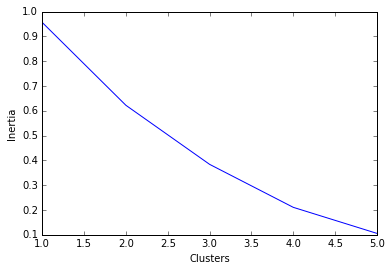

In [24]:
xaxis = range(1,6,1)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.plot(xaxis,inert)

3 clusters was chosen as optimal

In [25]:
kmeans = KMeans(n_clusters = 3, random_state=0).fit(X)
clusters = kmeans.predict(X)
centroids = kmeans.cluster_centers_

In [26]:
goog_words = goog_model.syn0

# Minkowski Distance

In [27]:
tree = BallTree(goog_words, leaf_size=2) 

In [28]:
wordindexes = []
for centroid in centroids:
    dist, ind = tree.query(centroid, k=3) 
    wordindexes.append(ind)

/Users/Sam/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Sam/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Sam/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

In [29]:
wordindices = []
for index in range(len(wordindexes)):
    for num in range(len(wordindexes[index][0])):
        if wordindexes[index][0][num] not in wordindices:
                wordindices.append(wordindexes[index][0][num])
            

In [30]:
for elem in wordindices:
    print goog_model.index2word[elem]

GREG_POTTER_Yes
TONY_STEWART_Yeah
KIM_CLIJSTERS_Yeah
MICHELLE_WIE_Yeah
%_#F########_3v.jsn
UDBKL
MVES_lunch
SECRETARY_RICE_Yeah


Better to use cosine distance for NLP.

# Cosine Distance with Nearest Neighbors

In [31]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='cosine')
neigh.fit(goog_words)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [32]:
wordindex_cos = []

for centroid in centroids:
    dist_cos, ind_cos = neigh.kneighbors(centroid, n_neighbors=100)
    wordindex_cos.append(ind_cos)

/Users/Sam/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Sam/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Sam/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

In [33]:
wordindices = []
for index in range(len(wordindex_cos)):
    for num in range(len(wordindex_cos[index][0])):
        if wordindex_cos[index][0][num] not in wordindices:
                wordindices.append(wordindex_cos[index][0][num])
            

In [34]:
for elem in wordindices:
    print goog_model.index2word[elem]

TONY_STEWART_Yeah
NOVAK_DJOKOVIC_Yeah
Pretty_classless
pioneer_LaLanne
KIM_CLIJSTERS_Yeah
SERENA_WILLIAMS_Well
TIM_HENMAN_Yeah
GREG_POTTER_Yes
COACH_BABCOCK
GEOFF_OGILVY_Yeah
PADRAIG_HARRINGTON_Yeah
Nick_HEIDFELD
really
ANDY_RODDICK_Yeah
JIM_FURYK_Yeah
MICHELLE_WIE_Yeah
SERENA_WILLIAMS_Yeah
Johnnie_Baston_die
just
GREG_BIFFLE_Yeah
Sebastian_VETTEL_Yeah
THE_PRESIDENT_Okay
Indeed_Rakieten
VENUS_WILLIAMS_Yeah
%_#F########_7v.jsn
innkeeper_Chirag_Patel
JELENA_JANKOVIC_Yeah
SCOTT_DIXON_Yeah
I'ma_stickler
COACH_FISHER
LH_Yeah
Choreographed_chaos
KEVIN_STREELMAN
anyway
ROGER_FEDERER_Yeah
By_Laurelle_Gilbert
JUSTINE_HENIN_Well
MARIA_SHARAPOVA_Uhm
HEATH_SLOCUM
Carpe_diem_seize
I
By_Jonas_Elmerraji
ANA_IVANOVIC_Yeah
JEFF_BURTON_Well
Trazanna_Moreno_decided
ERNIE_ELS_Yeah
ERNIE_ELS_Well
ROBERT_BLAGOJEVICH
Kimi_RÄIKKÖNEN
Anglo_Saxon_metalworkers
Tell_Squawk_Box
Rubens_BARRICHELLO
Wow_how'd
JAMES_BLAKE_Yeah
Pretty_darned
AMÉLIE_MAURESMO
JO_WILFRIED_TSONGA
ebullient_Ohno
Pure_unadulterated
carbonate

Printing lots of words completely unrelated to reviews. Try the Stanford pretrained Word2Vec instead.

# Stanford Wikipedia

In [35]:
stan_model = gensim.models.Word2Vec.load('w2v')

In [36]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [37]:
review_vec = []
for review in reviews:
    result = []
    words = review.split()
    for word in words:
        if word not in stop:
            try:
                result.append(stan_model[word.lower()])
            except:
                pass
    review_vec.append(np.array(result).mean(axis = 0))

In [38]:
stan_model.similar_by_vector(review_vec[0], topn = 500)

[(u'you', 0.8221941590309143),
 (u"n't", 0.7952711582183838),
 (u'so', 0.7886036038398743),
 (u'even', 0.7816715240478516),
 (u'just', 0.7696509957313538),
 (u'what', 0.7626189589500427),
 (u'?', 0.7589337825775146),
 (u'if', 0.756553590297699),
 (u'get', 0.7519210577011108),
 (u'but', 0.750282347202301),
 (u'good', 0.7486193180084229),
 (u'we', 0.7476129531860352),
 (u'i', 0.747099757194519),
 (u'really', 0.7457702159881592),
 (u'know', 0.7454687356948853),
 (u'because', 0.7430497407913208),
 (u'it', 0.7405262589454651),
 (u'something', 0.7401998043060303),
 (u'going', 0.7396260499954224),
 (u'sure', 0.7396171689033508),
 (u'things', 0.7392690777778625),
 (u'think', 0.7391953468322754),
 (u'make', 0.7352544069290161),
 (u'actually', 0.7339118719100952),
 (u"'ll", 0.7334117293357849),
 (u'want', 0.7326836585998535),
 (u'well', 0.7314688563346863),
 (u'not', 0.731255292892456),
 (u'come', 0.7303734421730042),
 (u'kind', 0.728805422782898),
 (u'they', 0.7282010912895203),
 (u'nothing', 0

Many words not related to food, price, restaurant etc. Try a different strategy.

Removing the first feature may result in more accuracy.

In [39]:
stan_words = stan_model.syn0

In [40]:
stan_words = stan_words[:, 1:]

In [41]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=100, algorithm='brute', metric='cosine')
neigh.fit(stan_words)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=100, p=2, radius=1.0)

In [42]:
review_test = review_vec[0][1:]

In [43]:
distances_stan, indices_stan = neigh.kneighbors(review_test, n_neighbors=100)

/Users/Sam/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [44]:
indices_stan = indices_stan[0]

In [45]:
for index in indices_stan:
    print stan_model.index2word[index]

you
n't
so
even
just
what
?
if
get
but
good
we
i
know
really
because
something
it
going
sure
think
things
actually
make
'll
want
well
come
not
they
kind
nothing
anything
way
thing
do
always
only
maybe
everything
enough
like
need
should
go
're
'd
this
much
better
one
can
same
might
all
've
how
why
that
time
too
probably
done
though
.
does
could
look
fact
there
them
did
never
put
else
thought
simply
me
lot
certainly
take
those
rather
would
few
very
whole
every
say
everyone
any
be
more
little
no
let
got
sort
having
instead


# TFIDF

In [5]:
reviews = db.reviews

In [6]:
datarev2 = list(reviews.find())

In [7]:
reviewdict = {}
for review in datarev2:
    bizid = review['business_id']
    bizrev = review['text']
    try:
        reviewdict[bizid] = reviewdict[bizid] + bizrev
    except:
        reviewdict[bizid] = bizrev

In [8]:
reviewlist_df = pd.DataFrame(reviewdict.items())

In [9]:
import pickle
with open('./reviewlist_df.pkl','wb') as f:
    pickle.dump(reviewlist_df, f)

In [10]:
tfidf = TfidfVectorizer(stop_words="english", 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", 
                        min_df=10)
tfidf_vecs = tfidf.fit_transform(reviewlist_df.iloc[:,1])

In [11]:
with open('./tfidf_vecs.pkl','wb') as f:
    pickle.dump([tfidf, tfidf_vecs], f)

In [12]:
id2words = dict((v, k) for k,v in tfidf.vocabulary_.iteritems())
vocabulary = tfidf.vocabulary_

In [13]:
with open('./words.pkl','wb') as f:
    pickle.dump([vocabulary, id2words], f) 

# Load Pickles here:

In [3]:
biz_id = '_qvxFHGbnbrAPeWBVifJEQ'

In [4]:
import pickle
with open('./reviewlist_df.pkl','rb') as f:
    reviewlist_df = pickle.load(f)

In [5]:
with open('./tfidf_vecs.pkl','rb') as f:
    tfidf, tfidf_vecs = pickle.load(f)

In [6]:
with open('./words.pkl', 'rb') as f:
    vocabulary, id2words = pickle.load(f)

In [7]:
biz_index = reviewlist_df[reviewlist_df[0] == biz_id].index[0]

In [8]:
tfidf_df = pd.DataFrame(tfidf_vecs.todense())

In [9]:
top_10 = tfidf_df.iloc[biz_index,:].argsort()[-10:]

In [10]:
for i in top_10[::-1]:
    print id2words[i] 

lenny
sub
philly
subs
toxic
sandwich
meat
subway
good
bread


In [22]:
review_summ = {}
for res in range(len(reviewlist_df[0])):
    top_10 = tfidf_df.iloc[res,:].argsort()[-10:]
    top_10_list = []
    for i in top_10[::-1]:
        top_10_list.append(id2words[i])
    review_summ[reviewlist_df[0][res]] = top_10_list

In [23]:
with open('./review_summ.pkl','wb') as f:
    pickle.dump(review_summ, f) 